In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import os
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn import metrics
import warnings
import matplotlib.pyplot as plt

from datetime import datetime as dt

warnings.filterwarnings('ignore')

### 赛题背景

**围网**

围网捕鱼就是专门为了捕捞在海面附近活动的鱼群所准备的，字面意思理解，就是用一张大网把鱼群围起来。为了完成这一系列作业，围网渔船需要有灵活的船身，这样方便快速的兜圈子。


**拖网**

拖网捕捞可以从字面意义上去解读，就是一艘船拖着渔网前进，把海里的鱼“兜”进去，然后收网。拖网是高能耗作业。


**刺网**

将长带形的网列敷设于水域中，使鱼刺入网目或被网衣缠络后加以捕捞的作业方式。网列由若干矩形网具连接而成，其长度可根据水域条件、渔船大小等因素确定，短则几十米，最长可达数千米。刺网渔具种类繁多，广泛应用于各国的捕捞业。

### 数据特征

#### 导入数据

In [2]:
train = pd.read_hdf('C:/Users/f3107/Desktop/hy_data/train_descending.h5')
train['datetime'] = pd.to_datetime(train['datetime'], format='%m%d %H:%M:%S')

In [6]:
train.head()

,ship_ID,x,y,speed_v,direction,datetime,type
413,0,6.118352e+06,5.130672e+06,0.0,0,1900-11-07 12:09:28,拖网
412,0,6.118352e+06,5.130672e+06,0.0,0,1900-11-07 12:18:30,拖网
411,0,6.118352e+06,5.130672e+06,0.0,0,1900-11-07 12:28:32,拖网
410,0,6.118352e+06,5.130672e+06,0.0,0,1900-11-07 12:38:32,拖网
409,0,6.118352e+06,5.130672e+06,0.0,0,1900-11-07 12:48:30,拖网


#### 时间间隔

In [8]:
#取所有船的的时间戳最小值 Timestamp('1900-10-28 00:00:02') - Timestamp('1900-11-23 23:59:59')
a = pd.Timestamp('1900-10-28 00:00:00')

train['seconds'] = train['datetime'] - a
train['seconds'] = train['seconds'].dt.seconds

In [9]:
train.head()

,ship_ID,x,y,speed_v,direction,datetime,type,seconds
413,0,6.118352e+06,5.130672e+06,0.0,0,1900-11-07 12:09:28,拖网,43768
412,0,6.118352e+06,5.130672e+06,0.0,0,1900-11-07 12:18:30,拖网,44310
411,0,6.118352e+06,5.130672e+06,0.0,0,1900-11-07 12:28:32,拖网,44912
410,0,6.118352e+06,5.130672e+06,0.0,0,1900-11-07 12:38:32,拖网,45512
409,0,6.118352e+06,5.130672e+06,0.0,0,1900-11-07 12:48:30,拖网,46110


In [15]:
for id, group in train['seconds'].groupby(train['ship_ID']):
    print(type(group.diff()))
    break

<class 'pandas.core.series.Series'>


### 单个船的状态
每个ship确定是只有一种状态

In [11]:
len(train.groupby(['ship','type']).count())

7000

### x,y坐标

x,y元数据做过变形

#### 均值散点图

在学习器中，最大值和最小值的重要性是最高的。

In [80]:
#坐标散点图，mean，max，min分布类似
def GPS_scatter(train_xy_label,attribute):
    fig, ax = plt.subplots(figsize = (15,12))
    plt.title(attribute)

    t = train_xy_label[train_xy_label['type'] == '拖网']    
    ax.scatter(t.x, t.y, label = 'tuo', marker = '^')

    t = train_xy_label[train_xy_label['type'] == '围网']    
    ax.scatter(t.x, t.y, label = 'wei', marker = 'o')

    t = train_xy_label[train_xy_label['type'] == '刺网']    
    ax.scatter(t.x, t.y, label = 'ci', marker = '+')

    ax.legend()

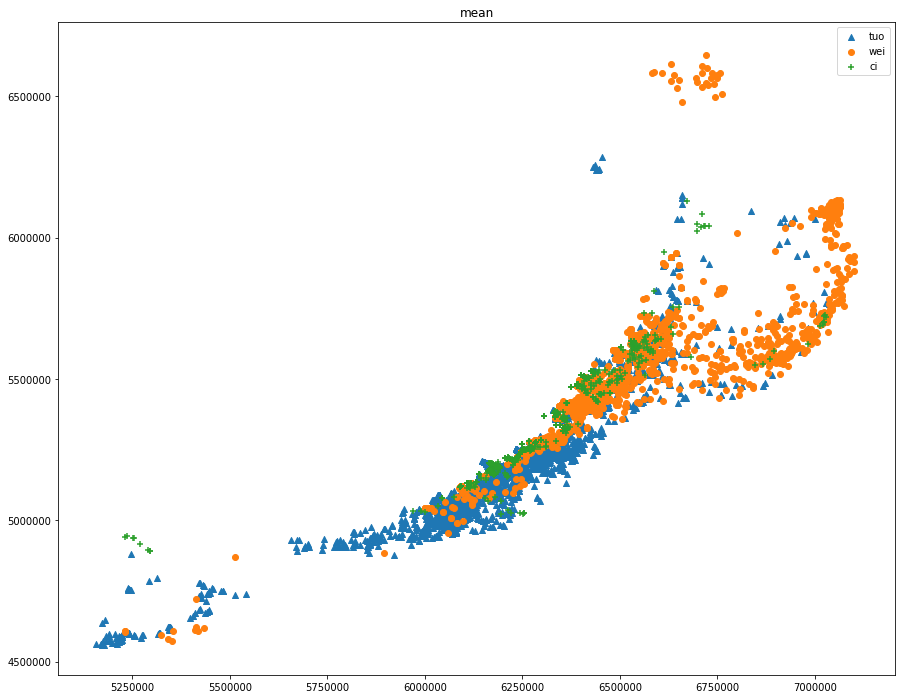

In [83]:
train_xy_mean = train[['x','y']].groupby(train['ship']).mean()
train_label = train.loc[:,['ship','type']].drop_duplicates('ship')

train_xy_label = pd.merge(train_xy_mean,train_label,on = 'ship')

GPS_scatter(train_xy_label,'mean')

#### 坐标密度直方图

目前重要性最高的特征

In [ ]:
#坐标密度直方图
def GPS_distplot(train_xy_label,attribute,z):
    fig, ax = plt.subplots(figsize = (15,8))
    plt.title(attribute)
    
    if z == 'x':

        t = train_xy_label[train_xy_label['type'] == '拖网'] 
        sns.distplot(t.x, bins = 200, kde = False, label = 'tuo')

        t = train_xy_label[train_xy_label['type'] == '围网'] 
        sns.distplot(t.x, bins = 200, kde = False, label = 'wei')

        t = train_xy_label[train_xy_label['type'] == '刺网'] 
        sns.distplot(t.x, bins = 200, kde = False, label = 'ci')
        
    if z == 'y':
        
        t = train_xy_label[train_xy_label['type'] == '拖网'] 
        sns.distplot(t.y, bins = 200, kde = False, label = 'tuo')

        t = train_xy_label[train_xy_label['type'] == '围网'] 
        sns.distplot(t.y, bins = 200, kde = False, label = 'wei')

        t = train_xy_label[train_xy_label['type'] == '刺网'] 
        sns.distplot(t.y, bins = 200, kde = False, label = 'ci')

    ax.legend()

In [86]:
train_xy_max = train[['x','y']].groupby(train['ship']).max()
train_label = train.loc[:,['ship','type']].drop_duplicates('ship')

train_xy_label = pd.merge(train_xy_mean,train_label,on = 'ship')

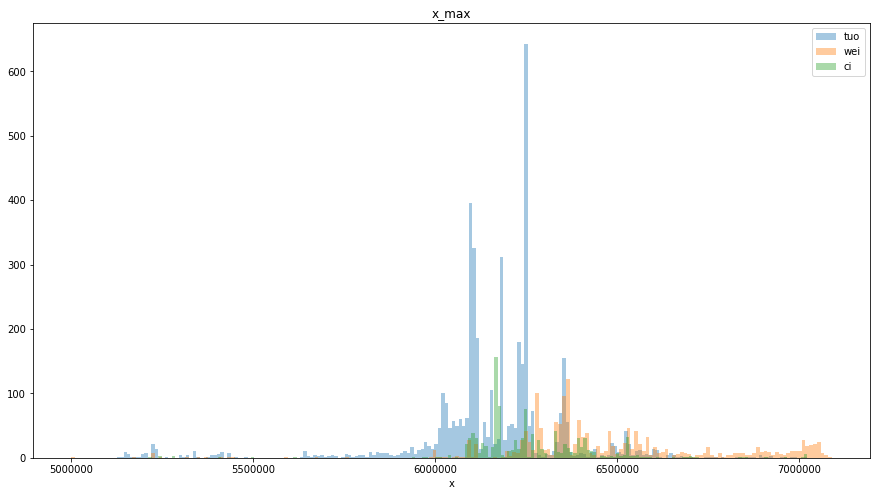

In [106]:
GPS_distplot(train_xy_label,'x_max','x')

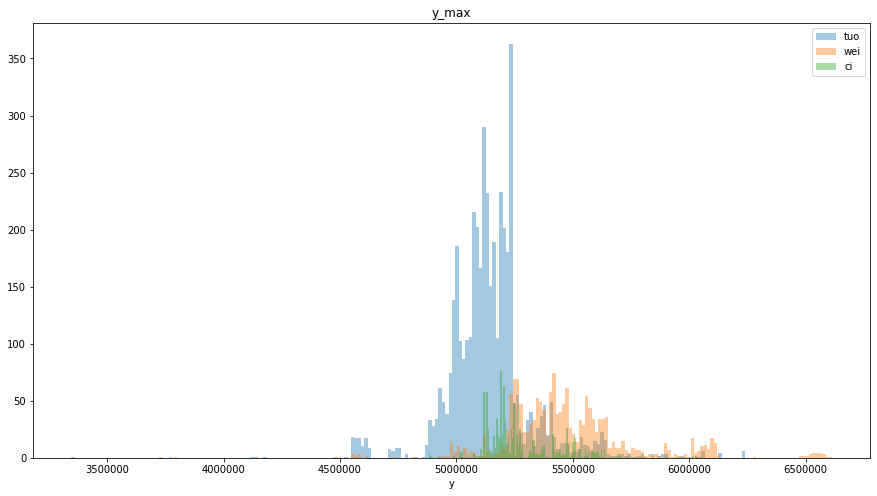

In [107]:
GPS_distplot(train_xy_label,'y_max','y')

#### 坐标轨迹

很多信号漂移严重

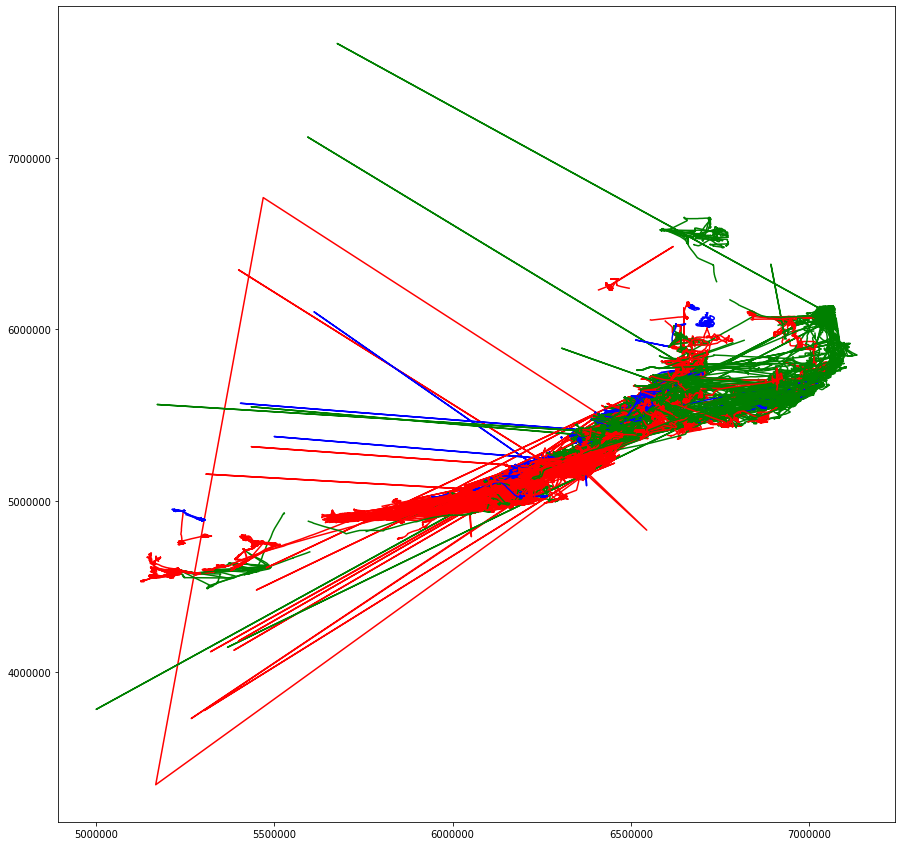

In [120]:
fig, ax = plt.subplots(figsize = (15,15))

for i in range(7000):
    t = train[train['ship'] == i]
    if t.loc[0,'type'] == '拖网':   
        plt.plot(t.x, t.y,color = 'red',label = 'tuo')
    if t.loc[0,'type'] == '围网':
        plt.plot(t.x, t.y,color = 'green',label = 'wei')
    if t.loc[0,'type'] == '刺网':
        plt.plot(t.x, t.y,color = 'blue',label = 'ci')

ax.legend()

In [123]:
train['time'] = pd.to_datetime(train['time'], format='%m%d %H:%M:%S')

In [138]:
train['second'] =train['time'].dt.time

In [143]:
train.head()

,ship,x,y,v,d,time,type,second
0,0,6.152038e+06,5.124873e+06,2.59,102,1900-11-10 11:58:19,拖网,11:58:19
1,0,6.151230e+06,5.125218e+06,2.70,113,1900-11-10 11:48:19,拖网,11:48:19
2,0,6.150421e+06,5.125563e+06,2.70,116,1900-11-10 11:38:19,拖网,11:38:19
3,0,6.149612e+06,5.125907e+06,3.29,95,1900-11-10 11:28:19,拖网,11:28:19
4,0,6.148803e+06,5.126252e+06,3.18,108,1900-11-10 11:18:19,拖网,11:18:19


In [159]:
p = pd.Timestamp(dt(1900,1,1,hour=0,minute=0,second=0))
p

Timestamp('1900-01-01 00:00:00')

In [161]:
train['s'] = train.time - p

In [162]:
train.head()

,ship,x,y,v,d,time,type,second,s
0,0,6.152038e+06,5.124873e+06,2.59,102,1900-11-10 11:58:19,拖网,11:58:19,313 days 11:58:19
1,0,6.151230e+06,5.125218e+06,2.70,113,1900-11-10 11:48:19,拖网,11:48:19,313 days 11:48:19
2,0,6.150421e+06,5.125563e+06,2.70,116,1900-11-10 11:38:19,拖网,11:38:19,313 days 11:38:19
3,0,6.149612e+06,5.125907e+06,3.29,95,1900-11-10 11:28:19,拖网,11:28:19,313 days 11:28:19
4,0,6.148803e+06,5.126252e+06,3.18,108,1900-11-10 11:18:19,拖网,11:18:19,313 days 11:18:19


In [ ]:
t = train[train['ship'] == 1001]

fig, ax = plt.subplots(1,3, figsize=(15,8))
ax[0,0].plot()

In [ ]:
def show_path(type_name):
    ids = train[train['type']==type_name]['ship'].unique()
    ids = [ids[np.random.randint(len(ids))] for x in range(10)]
    t = train[train['ship'].isin(ids)]

    f, ax = plt.subplots(5,2, figsize=(8,20))
    for index, cur_id in enumerate(ids):
        cur = t[t['ship']==cur_id]
        i = index//2
        j = index % 2
        ax[i,j].plot(cur['x'], cur['y'])
#         if i==0 and j==0:
        ax[i,j].set_title(cur_id)

In [5]:
random_train = train[train['ship'] == 1001]

Text(0.5, 1.0, "['拖网']")

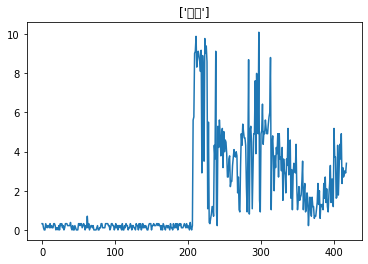

In [22]:
plt.plot(random_train['v'])
plt.title(train['type'][train['ship'] == 1001].unique())

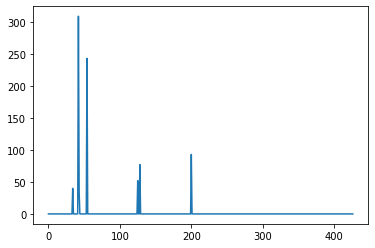

In [53]:
plt.plot(t['d'])

In [45]:
def show_path(type_name):
    ids = train[train['type']==type_name]['ship'].unique()
    ids = [ids[np.random.randint(len(ids))] for x in range(10)]
    t = train[train['ship'].isin(ids)]

    f, ax = plt.subplots(5,2, figsize=(8,20))
    for index, cur_id in enumerate(ids):
        cur = t[t['ship']==cur_id]
        i = index//2
        j = index % 2
        ax[i,j].plot(cur['x'], cur['y'])
#         if i==0 and j==0:
        ax[i,j].set_title(cur_id)

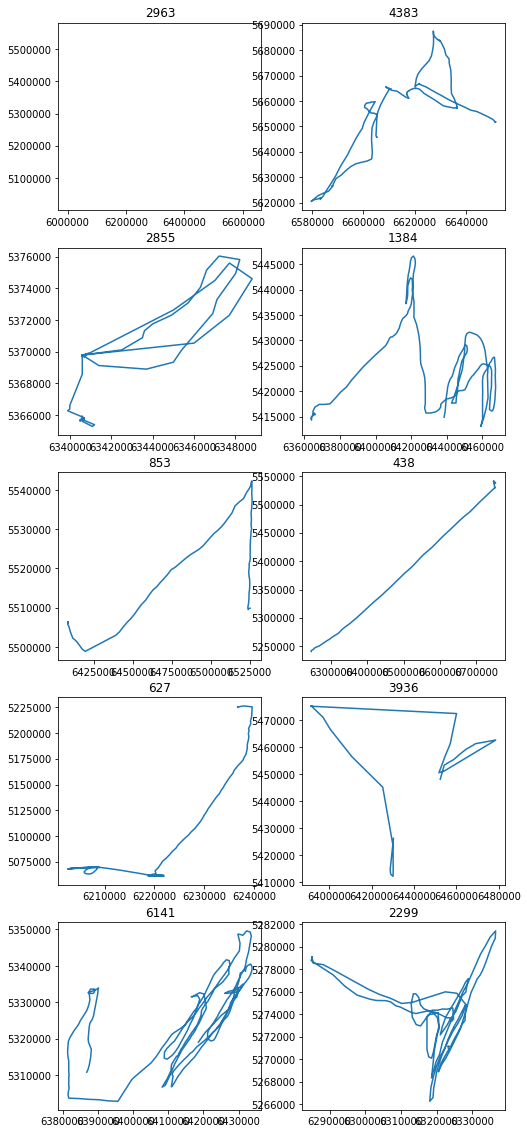

In [46]:
show_path('围网')

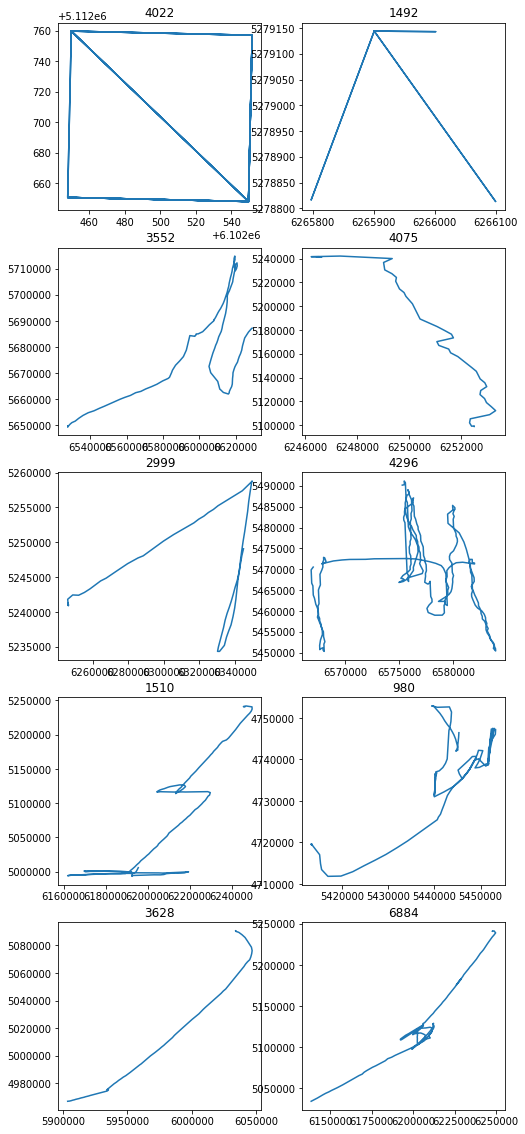

In [47]:

show_path('拖网')

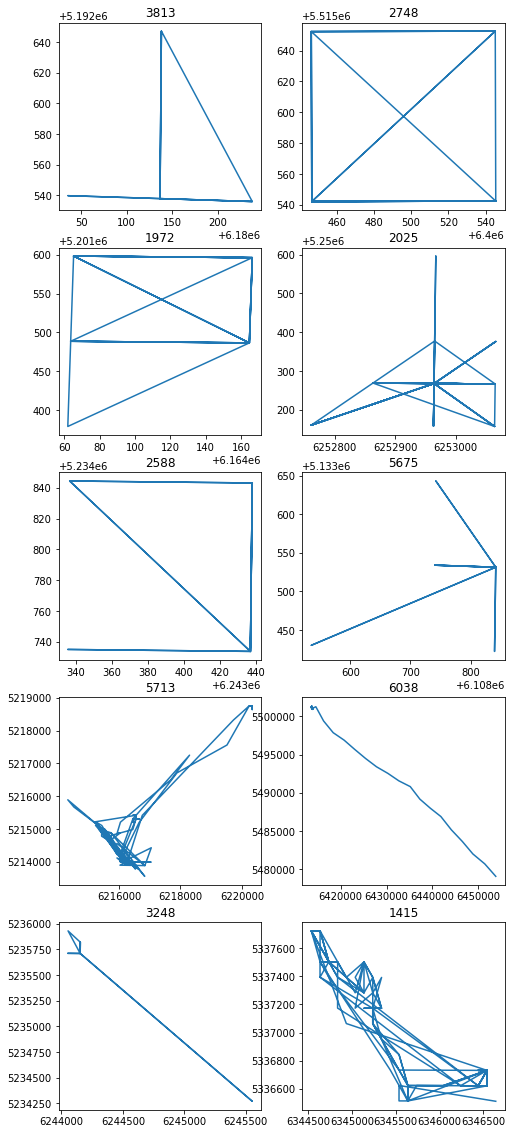

In [48]:
show_path('刺网')